## Описание проекта

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Задача: Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Этапы:

* загрузка и ознакомление с данными
* предварительная обработка
* полноценный разведочный анализ
* разработка новых синтетических признаков
* проверка на мультиколлинеарность
* отбор финального набора обучающих признаков
* выбор и обучение моделей
* итоговая оценка качества предсказания лучшей модели
* анализ важности ее признаков
* написать вывод

Описание данных:

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - базовый ключ (нота) произведения
* liveness - привлекательность
* loudness - громкость
* mode - указывает на модальность (мажорную или минорную) трека
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Импорт необходимых библиотек

In [1]:
! pip install -q kaggle
! pip install -q catboost
! pip install -q phik
! pip install -q stop-words
! pip install -q pandarallel
! pip install -q optuna

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils import shuffle
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import seaborn
from google.colab import files
import os
import re
import warnings
import math
from pandarallel import pandarallel
from string import punctuation
from nltk.stem import PorterStemmer
from gensim import corpora
import gensim
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import torch
import optuna

## Загрузка данных из Kaggle

In [6]:
#files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c music-genre-prediction-m124ds
! mkdir music_genre
! unzip music-genre-prediction-m124ds.zip -d music_genre

 79% 1.00M/1.27M [00:00<00:00, 1.98MB/s]
100% 1.27M/1.27M [00:00<00:00, 2.38MB/s]
Archive:  music-genre-prediction-m124ds.zip
  inflating: music_genre/kaggle_music_genre_test.csv  
  inflating: music_genre/kaggle_music_genre_train.csv  
  inflating: music_genre/sample_submit.csv  


In [6]:
warnings.filterwarnings('ignore')
data_path = '/content/music_genre'
st = 12345

In [7]:
data = pd.read_csv(os.path.join(data_path, 'kaggle_music_genre_train.csv')) # основной датасет
data.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
4567,60194.0,Wild Wild West - Album Version - No Intro,0.06150,0.846,245533.0,0.659,0.000000,A#,0.2970,-6.888,Minor,0.0809,107.014,4-Apr,0.622,Rap
15496,44923.0,Una Mattina - Original Mix,0.30700,0.808,368488.0,0.480,0.870000,B,0.0833,-15.280,Minor,0.0618,116.006,4-Apr,0.352,Electronic
12423,66747.0,Things Can Only Get Better,0.03140,0.752,235827.0,0.743,0.000117,G,0.1280,-6.083,Major,0.0331,108.254,4-Apr,0.832,Rock
8125,44742.0,Nothing but Trouble - Instagram Models,0.01720,0.724,217984.0,0.691,0.000017,F#,0.1940,-5.665,Minor,0.0324,126.002,4-Apr,0.236,Rap
15041,42630.0,Floods,0.00268,0.364,419893.0,0.811,0.009300,B,0.1060,-7.237,Major,0.0621,120.758,4-Apr,0.151,Alternative


In [8]:
submits = pd.read_csv(os.path.join(data_path, 'sample_submit.csv')) # пример ответов
submits.sample(5)

,instance_id,music_genre
2430,74065,Rock
1279,75548,Anime
2161,78936,Rock
4936,22034,Classical
4462,26366,Classical


In [9]:
data_test = pd.read_csv(os.path.join(data_path, 'kaggle_music_genre_test.csv')) # тестовый датасет
data_test.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
4125,88175,GOZA - Alvaro Remix,0.049500,0.714,160000.0,0.872,0.034100,B,0.1060,-7.324,Major,0.2170,149.879,4-Apr,0.391
2923,62243,Início,0.000825,0.449,206675.0,0.894,0.896000,C,0.0759,-8.014,Major,0.0879,161.012,4-Apr,0.161
4407,23484,The Worst,0.237000,0.524,254493.0,0.417,0.000001,C#,0.1390,-9.283,Minor,0.0578,93.590,4-Apr,0.109
507,32903,Sanctuary,0.006970,0.485,310433.0,0.943,0.000000,G,0.0678,-2.601,Major,0.0455,91.008,4-Apr,0.422
510,59070,Stages,0.051900,0.453,212027.0,0.787,0.004780,G,0.1660,-13.397,Major,0.0327,75.876,4-Apr,0.834


Данные загрузил с платформы Kaggle, и открыл для просмотра.

## Предобработка и анализ

### Первичный анализ

In [10]:
print(data.info(), '\n')
print('nan %: \n', data.isna().sum()/data.shape[0]*100, '\n')
print('duplicates:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [11]:
print('Количество уникальных композиций:', len(data.instance_id.unique()))

Количество уникальных композиций: 20394


Видно, что нескольких столбцах есть пропуски. С типами данных все в порядке. Явных дубликатов нет.

In [12]:
print(data_test.info(), '\n')
print('nan %: \n', data_test.isna().sum()/data_test.shape[0]*100, '\n')
print('duplicates:', data_test.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB
None 

nan %: 
 instance_id  

In [13]:
print('Количество уникальных композиций:', len(data_test.instance_id.unique()))

Количество уникальных композиций: 5099


Есть пропуски в столбце key, mode, tempo. С типами все в порядке.

Рассмотрим категориальные признаки.

In [14]:
print('unique track_name %:', round(len(data.track_name.unique())/data.shape[0]*100, 2))

unique track_name %: 91.41


Имеются дубликаты в колонке с названием композиции, однока с этим ничего не поделать. У 9% совпадают названия.

In [15]:
key_s = data.key.unique()
key_s

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

В колонке key нет неявных дубликатов.

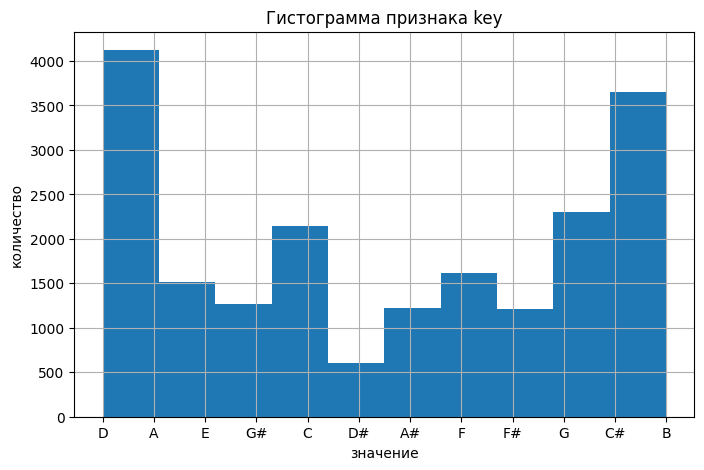

In [16]:
plt.figure(figsize=(8, 5))
plt.title('Гистограмма признака key')
plt.ylabel('количество')
plt.xlabel('значение')
data.key.hist();

* Из гистограммы видно, что наиболее встречающиеся ключи: D, B, C#.

* В данном столбце есть пропуски, однако заменить их на наиболее встречающееся значение будет нелогично, так как уникальных значений много. Поэтому заменим на '_'.

In [17]:
data.loc[(data['music_genre']=='Classical') & (data['key'].isna()), 'track_name'].unique()

array(['Serenade in B flat, K.361 "Gran partita": 3. Adagio',
       'Violin Concerto No. 3 in G Major, K. 216: II. Adagio (Cadenza: Yakov Kreizberg)',
       'Schübler Chorale Preludes: Schübler Chorale Preludes: VI. "Kommst du nun, Jesu, vom Himmel herunter", BWV 650',
       'Les Chansons des roses: No. 5. Dirait-on',
       'A Spacetime Singularity',
       'Horn Concerto No. 4 in E Flat, K. 495 : 2. Romanza (Andante)',
       'Piano Concerto In D Minor, K. 466; 1st Movement',
       'Piano Sonata in F Major, KV332: I. Allegro', 'Fragment II',
       'Damn Good',
       'Falstaff, Act I Pt. 1: Sei polli, sei scellini (Live)',
       'Liebestraum No. 3 in A-Flat Major, S. 541/3',
       'St. John Passion, BWV 245, Pt. 2: No. 40, Ach Herr, lass dein lieb Engelein',
       'Symphony No. 3 in E-Flat Major, Op. 55 "Eroica": I. Allegro con brio (Live)',
       'Piano Concerto No. 3 in D Major, K. 40: I. Allegro maestoso (After L. Honauer, Op. 2 No. 1)',
       'String Quartet No. 3, "Mis

В названиях классических произведений часто пишут тональность, я написал функцию, которая вытаскивает данный признак из track_name.

In [18]:
def key_nan(raw):
    for t in key_s:
        if type(t)!=float:
            if raw.track_name.find(' '+t+' ')>-1:
                return t
    return '_'

In [19]:
data.loc[((data['music_genre']=='Classical')&
 (data['key'].isna())), 'key'] = data.loc[(data['music_genre']=='Classical')&(data['key'].isna())].apply(key_nan,
                                                                                                         axis=1)

data.key.isna().sum()/data.shape[0]*100

3.4078650583504952

С помощью данного метода правильно заменили пропуски и уменьшили их количестов с 3.6% до 3.4%. Осатвшиеся пропуски заменим "_".

In [20]:
data_test.loc[data_test['key'].isna(), 'key'] = data_test.loc[data_test['key'].isna()].apply(key_nan, axis=1)
data_test.key.isna().sum()/data_test.shape[0]*100

0.0

Аналогичные преобразования с тестовыми данными.

In [21]:
data.loc[data['key'].isna(), 'key'] = '_'
data_test.loc[data_test['key'].isna(), 'key'] = '_'
data.key.isna().sum()

0

In [22]:
data['mode'].unique()

array(['Major', 'Minor', nan], dtype=object)

В mode неявных дубликатов нет.

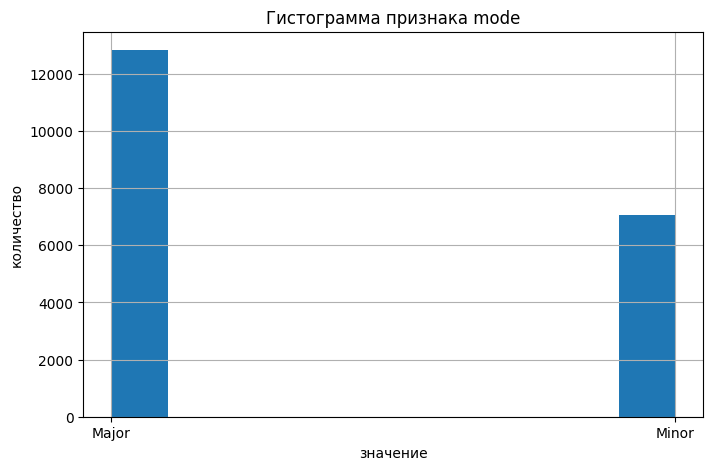

In [23]:
plt.figure(figsize=(8, 5))
plt.title('Гистограмма признака mode')
plt.ylabel('количество')
plt.xlabel('значение')
data['mode'].hist();

* Major наиболее встрпечающийся лад в датасете.

* В данном случае заменим пропуски на Major, как наиболее частое значение, так как уникальных значений всего два.

In [24]:
data_test.loc[data_test['mode'].isna(), 'mode'] = data['mode'].mode()[0]
data.loc[data['mode'].isna(), 'mode'] = data['mode'].mode()[0]
data['mode'].isna().sum()

0

In [25]:
data['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

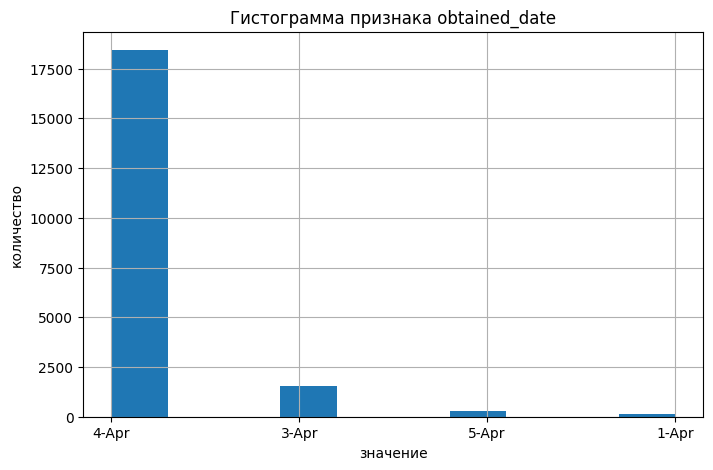

In [26]:
plt.figure(figsize=(8, 5))
plt.title('Гистограмма признака obtained_date')
plt.ylabel('количество')
plt.xlabel('значение')
data['obtained_date'].hist();

Большинство данных были загружены 4го апреля, однако дата загрузки в сервис логически не связаны с жанром композиции. Поэтому удалим этот признак.

In [27]:
data.music_genre.unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

Неявных дубликатов не выявлено.

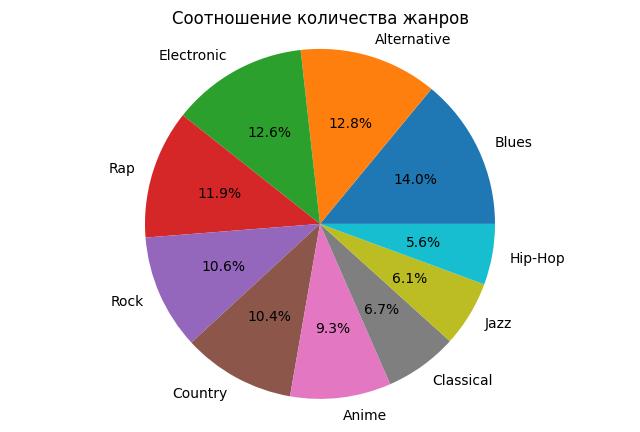

Соотношение количества каждой категории жанра:
music_genre
Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: count, dtype: int64


In [28]:
genre_counts = data['music_genre'].value_counts()
plt.figure(figsize=(8, 5))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Соотношение количества жанров')
plt.show()

print("Соотношение количества каждой категории жанра:")
print(genre_counts)

Из диаграммы видно, что больше всего блюза (примерно 14%), а меньше всего hip-hop и jazz (5.6% и 6.1%), при разбиении можно использовать параметр стратификации для сбалансированности данных.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               20394 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              20394 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [30]:
numeric = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
           'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

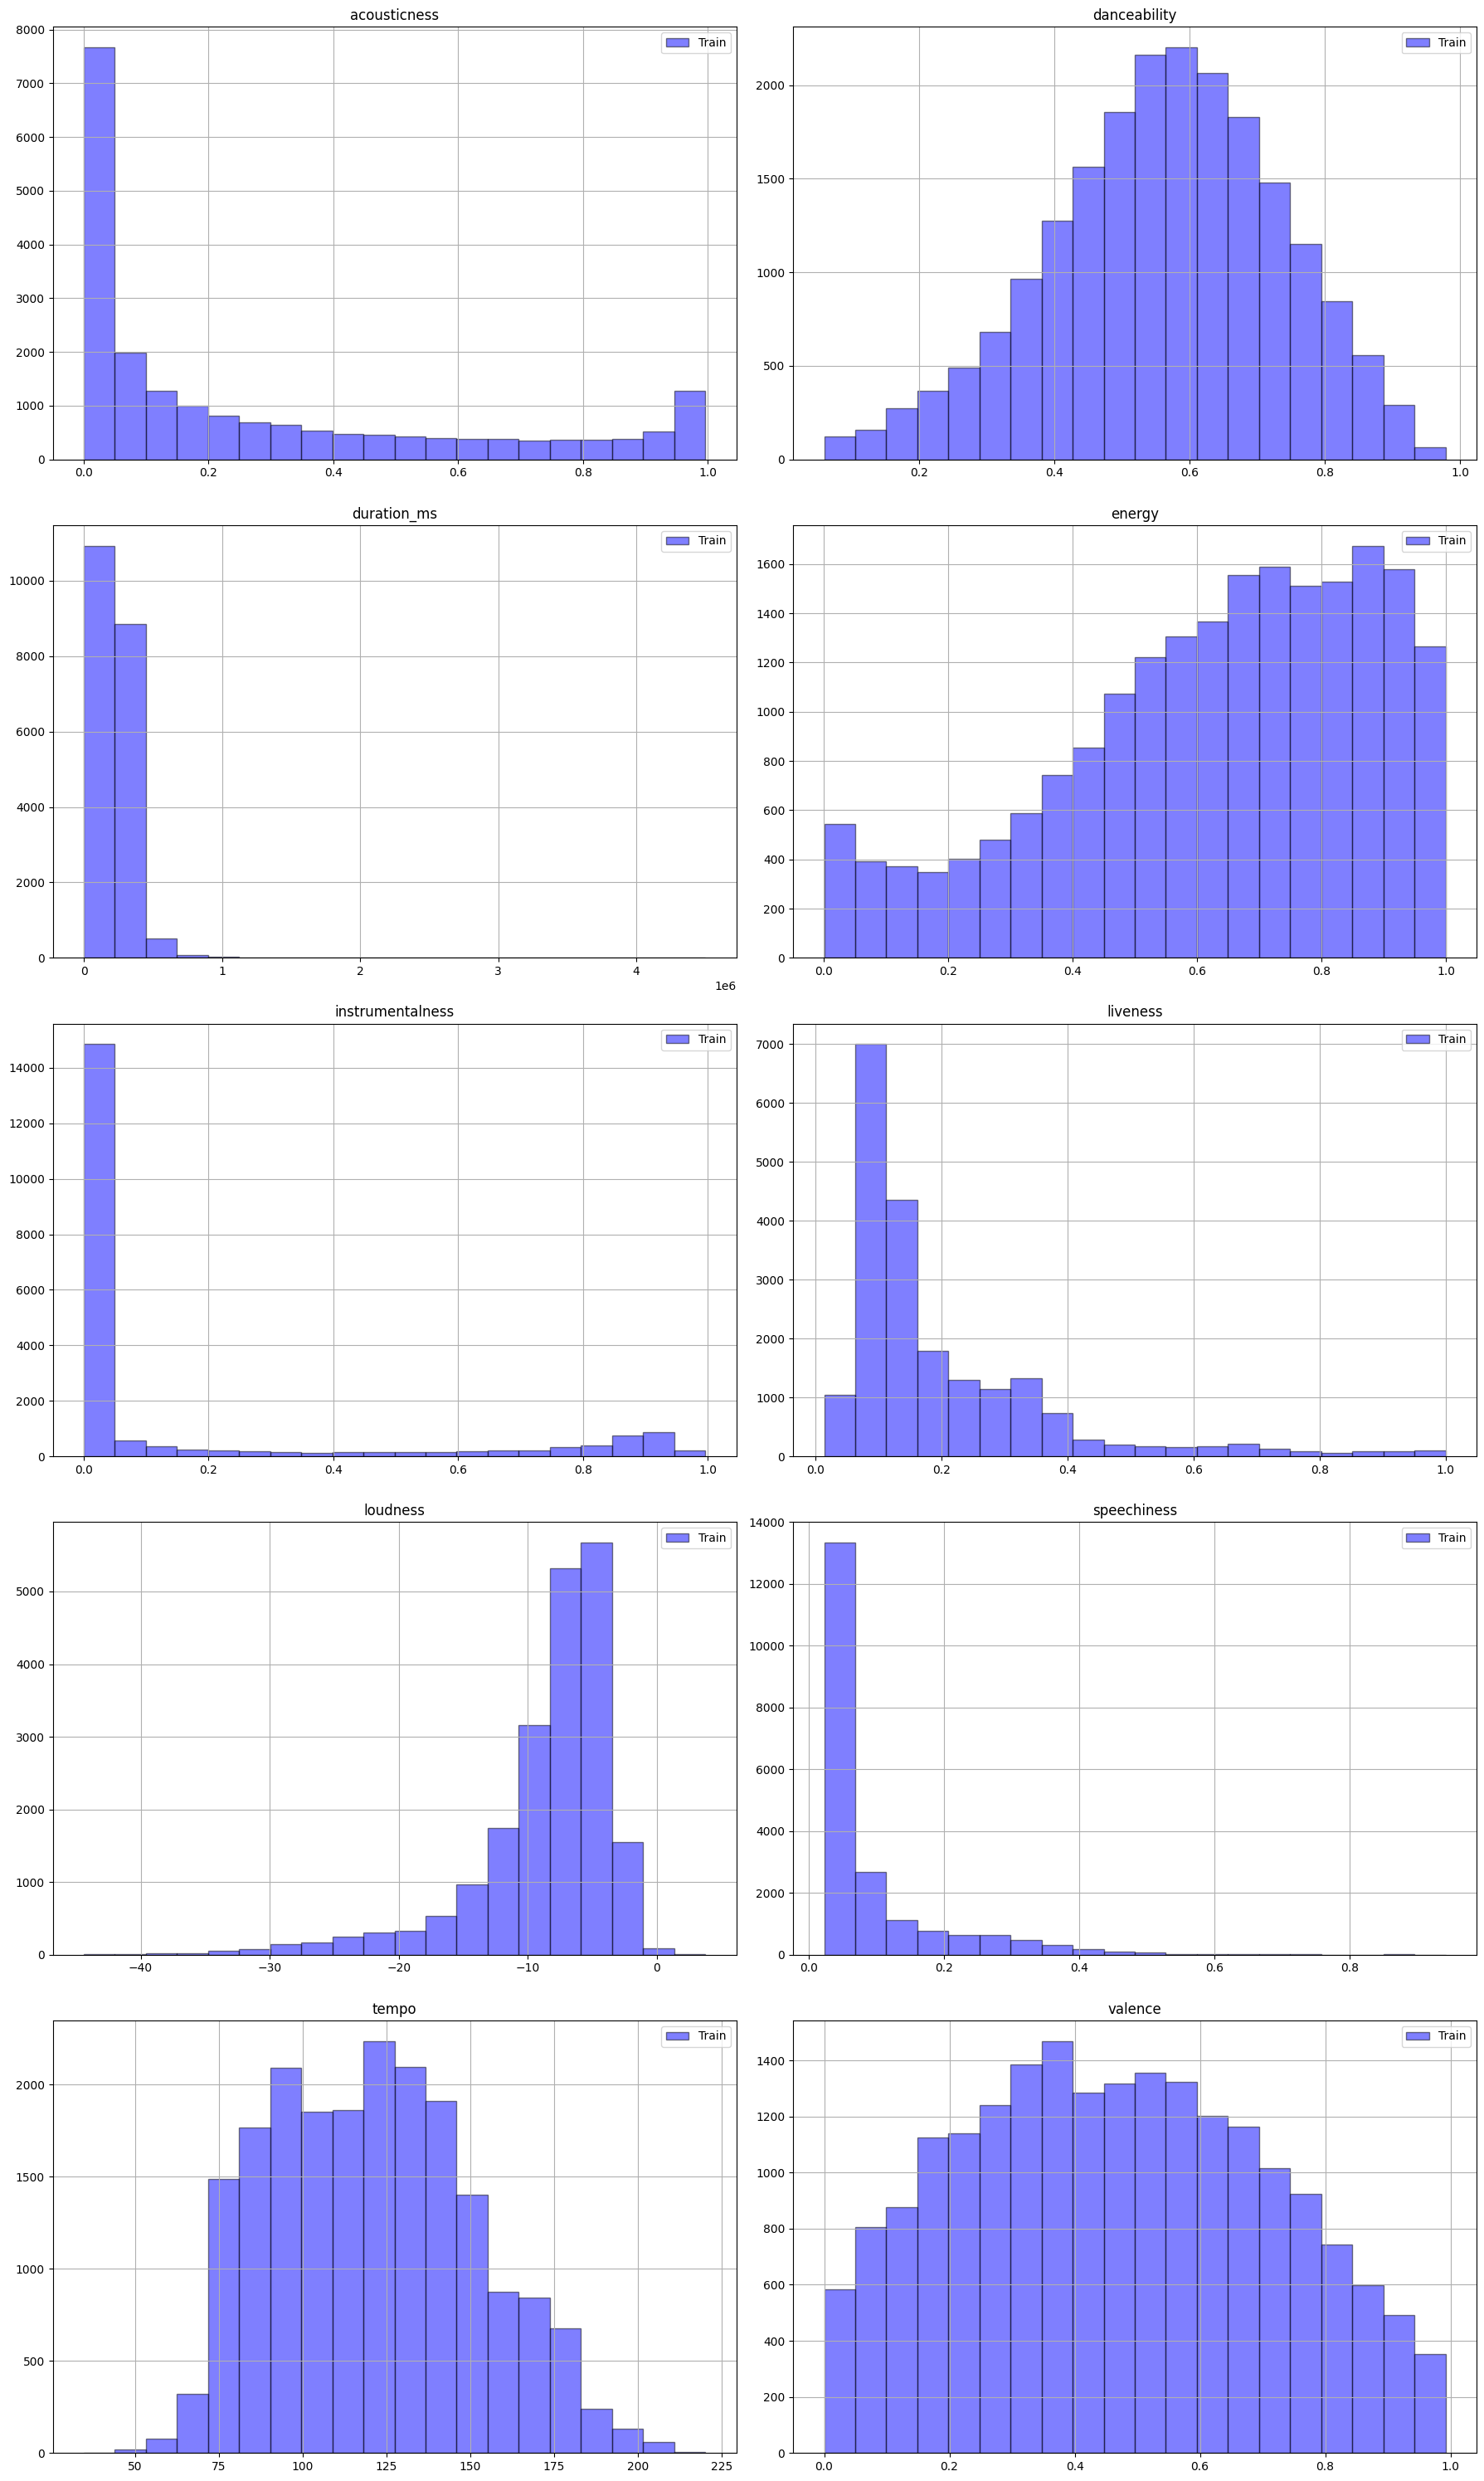

In [31]:
num_cols = 2
num_rows = (len(numeric)+num_cols-1)//num_cols
plt.figure(figsize=(18, 6*num_rows))
for i, column in enumerate(numeric):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(data[column], bins=20, color='blue', edgecolor='black', alpha=0.5, label='Train')
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

Рассмотрим распределение признаков:

* Большинство данных имеют акустичность меньше 0.2 или близкую к 1

* Распределение танцевальности напоминает нормальное распределение со смещением, где пик приходится на 0.6

* Большинство композиций не длятся более 0.5*10^6 милисекунд.

* Энергичность оценивается от 0 до 1, где у большинства композиций этот признак более 0.5

* У более 14000 композиций инструментальность близка к 0.

* Более 14000 композиций имеют привлекательность меньшию или равную 0.2

* Большинство композиций имеют отрицательную громкость, не совсем понятно в каких величинах это измеряется, лучше всего будет уточнить этот признак у датасаентистов.

* Выразительность большинства композиций от 0 до 0.2

* По темпу обширный спектр композиций. Пик приходится на 125.

* Привлекательность произведения для пользователей сервиса измеряется от 0 до 1, где большинстов оценены 0.4. 

In [32]:
for c in numeric:
    print(f'Values of {c}:\t')
    print(data[c].describe(), '\n')

Values of acousticness:	
count    20394.000000
mean         0.274783
std          0.321643
min          0.000000
25%          0.015200
50%          0.120000
75%          0.470000
max          0.996000
Name: acousticness, dtype: float64 

Values of danceability:	
count    20394.000000
mean         0.561983
std          0.171898
min          0.060000
25%          0.451000
50%          0.570000
75%          0.683000
max          0.978000
Name: danceability, dtype: float64 

Values of duration_ms:	
count    2.039400e+04
mean     2.203754e+05
std      1.267283e+05
min     -1.000000e+00
25%      1.775170e+05
50%      2.195330e+05
75%      2.660000e+05
max      4.497994e+06
Name: duration_ms, dtype: float64 

Values of energy:	
count    20394.000000
mean         0.625276
std          0.251238
min          0.001010
25%          0.470000
50%          0.666000
75%          0.830000
max          0.999000
Name: energy, dtype: float64 

Values of instrumentalness:	
count    20394.000000
mean       

Из анализа количественных признаков видим, что

* большинство признаков распределены на промежутке [0; 1]

* loudness имеет как отрицателные, так и полжительные значения, этот признак, как и tempo, необходимо масштабировать

* В duration_ms есть отрицательные значения, рассмотрю тщательнее этот признак

In [33]:
print(round(data.loc[data['duration_ms']<0, 'instance_id'].count()/data.shape[0]*100, 2), '%')

9.85 %


Около 10% данных в duration_ms <0. Это довольно много, чтобы потерять эти данные. Возможно никоректно выбрана единица измерения или ошибка при переносе данных. На всякий случай заменю отрицательные значения на медианные.

In [34]:
data.loc[data['duration_ms']<0, 'duration_ms'] = data.duration_ms.median()
print(data.duration_ms.describe())

count    2.039400e+04
mean     2.420016e+05
std      1.039616e+05
min      1.550900e+04
25%      1.960892e+05
50%      2.195330e+05
75%      2.660000e+05
max      4.497994e+06
Name: duration_ms, dtype: float64


Заменим в tempo пропуски на медианные значения.

In [35]:
data_test.loc[data_test['tempo'].isna(), 'tempo'] = data['tempo'].median()
data.loc[data['tempo'].isna(), 'tempo'] = data['tempo'].median()
data.isna().sum()

,0
instance_id,0
track_name,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0


In [36]:
data_test.isna().sum()

,0
instance_id,0
track_name,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0


In [37]:
data = data.drop('instance_id', axis=1)
test_id = data_test['instance_id']# пригодится, чтобы итоговый файл с ответами привести к требуемому формату
data_test = data_test.drop('instance_id', axis=1)

Убрал столбец с id трека, так как он не несет никакой информации о жанре.

In [38]:
data.head(2)

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,Highwayman,0.480,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,Toes Across The Floor,0.243,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock


* Обработал пропуски в столбце key, mode, tempo.

* Проанализировал распределение признаков

* Обработал аномальные значения в duration_ms

### Анализ зависимостей признаков

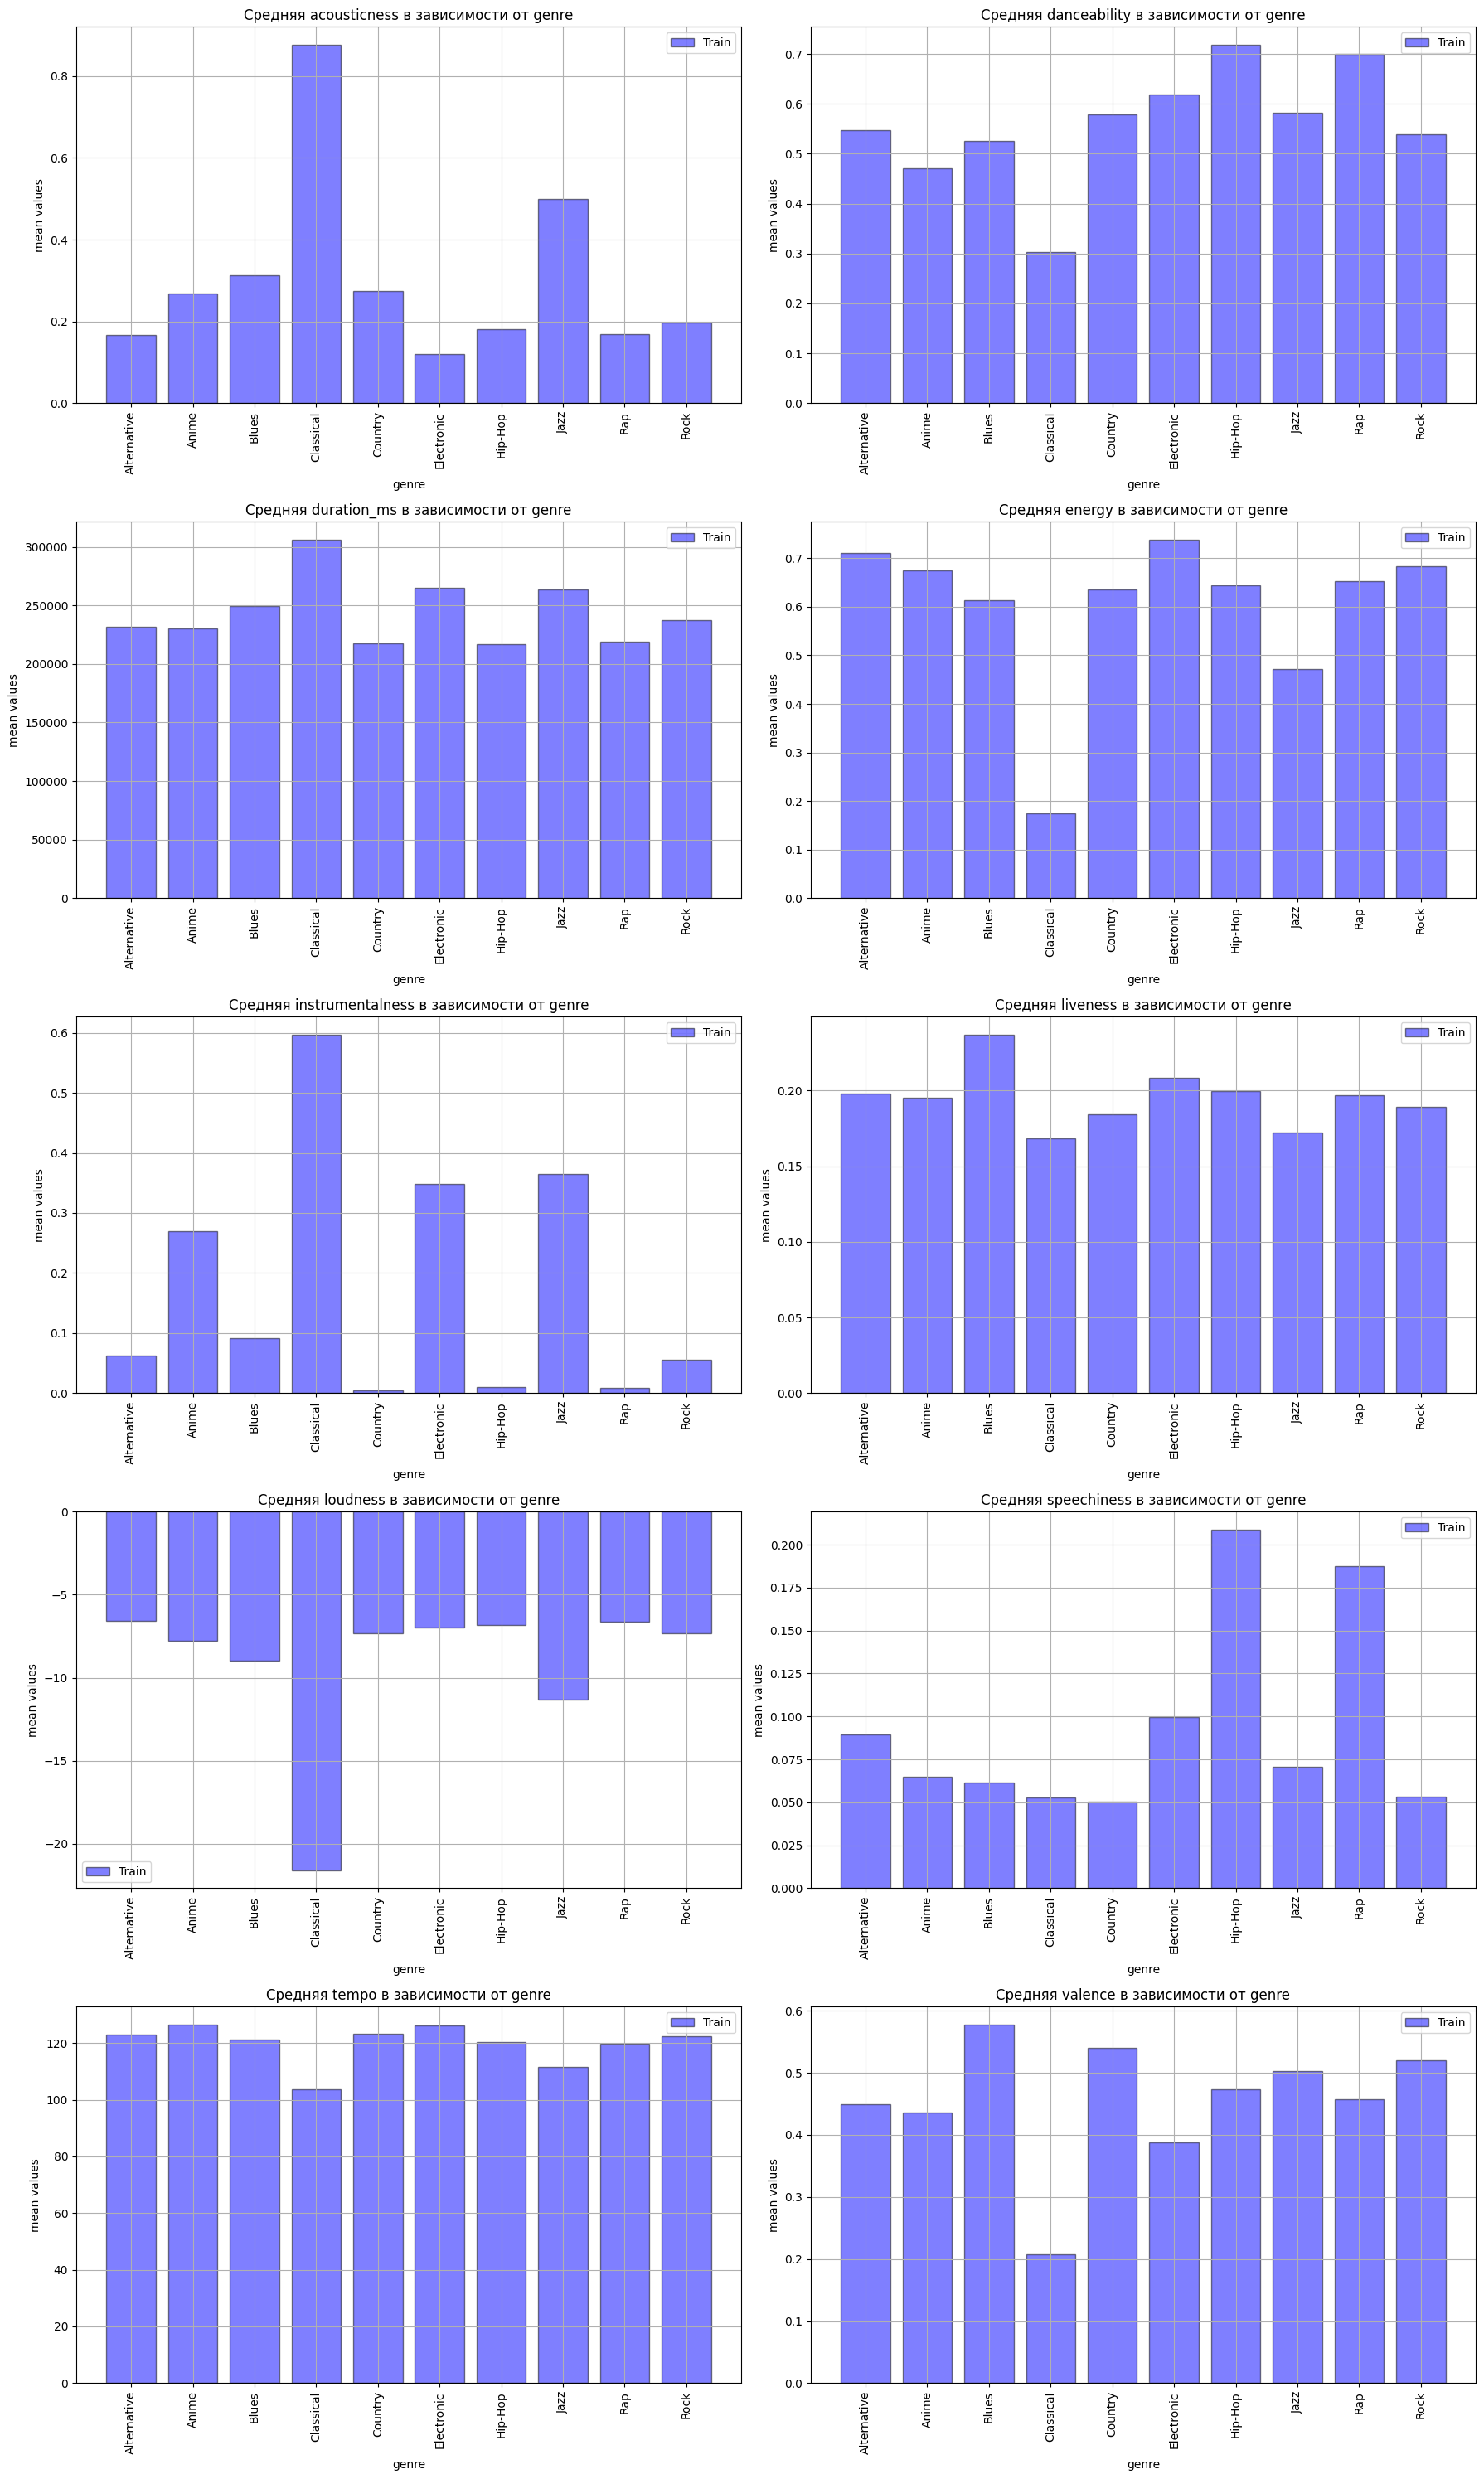

In [39]:
genre = data['music_genre'].value_counts()
num_cols = 2
num_rows = (len(numeric)+num_cols-1)//num_cols
plt.figure(figsize=(18, 6*num_rows))
for i, column in enumerate(numeric):
    plt.subplot(num_rows, num_cols, i+1)
    genre_mean = data.query('music_genre in (@genre.index)').pivot_table(index = 'music_genre',\
                                                                         values = column,\
                                                                         aggfunc='mean')
    plt.bar(genre_mean.index, genre_mean.values.transpose()[0], color='blue', edgecolor='black', alpha=0.5, label='Train')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.title(f'Средняя {column} в зависимости от genre')
    plt.xlabel('genre')
    plt.ylabel('mean values')

plt.tight_layout()
plt.show();

* Можем выделить classical, electronic и jazz в зависимости от акустичности.

* Classical имеет наименьшею танцевальность, а Hip-hop и Rap максимальную.

* По продолжительности можно выделить classical, country  и hip-hop, у этих жанров экстремальные значения.

* Electronic является самым энергичным жанром, тогда как classical - наименее.    

* По инструментальности снова выделяется Classical.

* Blues наиболее привлекательный жанр. Classical - наименее.

* Громкость у всех жанров примерно одинаковая, однако значении громкости у Classical отличется от других примерно в три раза.

* Cамыми выразительными являются Rap и Hip-Hop.

* Наименьшие показатели темпа у Classical и Jazz, у остальных теемп мало отличается.    

* Экстремальные значения привлекательности пользователей сервиса совпадают с привлекательностью, это Classical, Blues, Country.

* Blues и Country имеют очень схожие характеристики(темп, акустичность, громкость, энергичность)

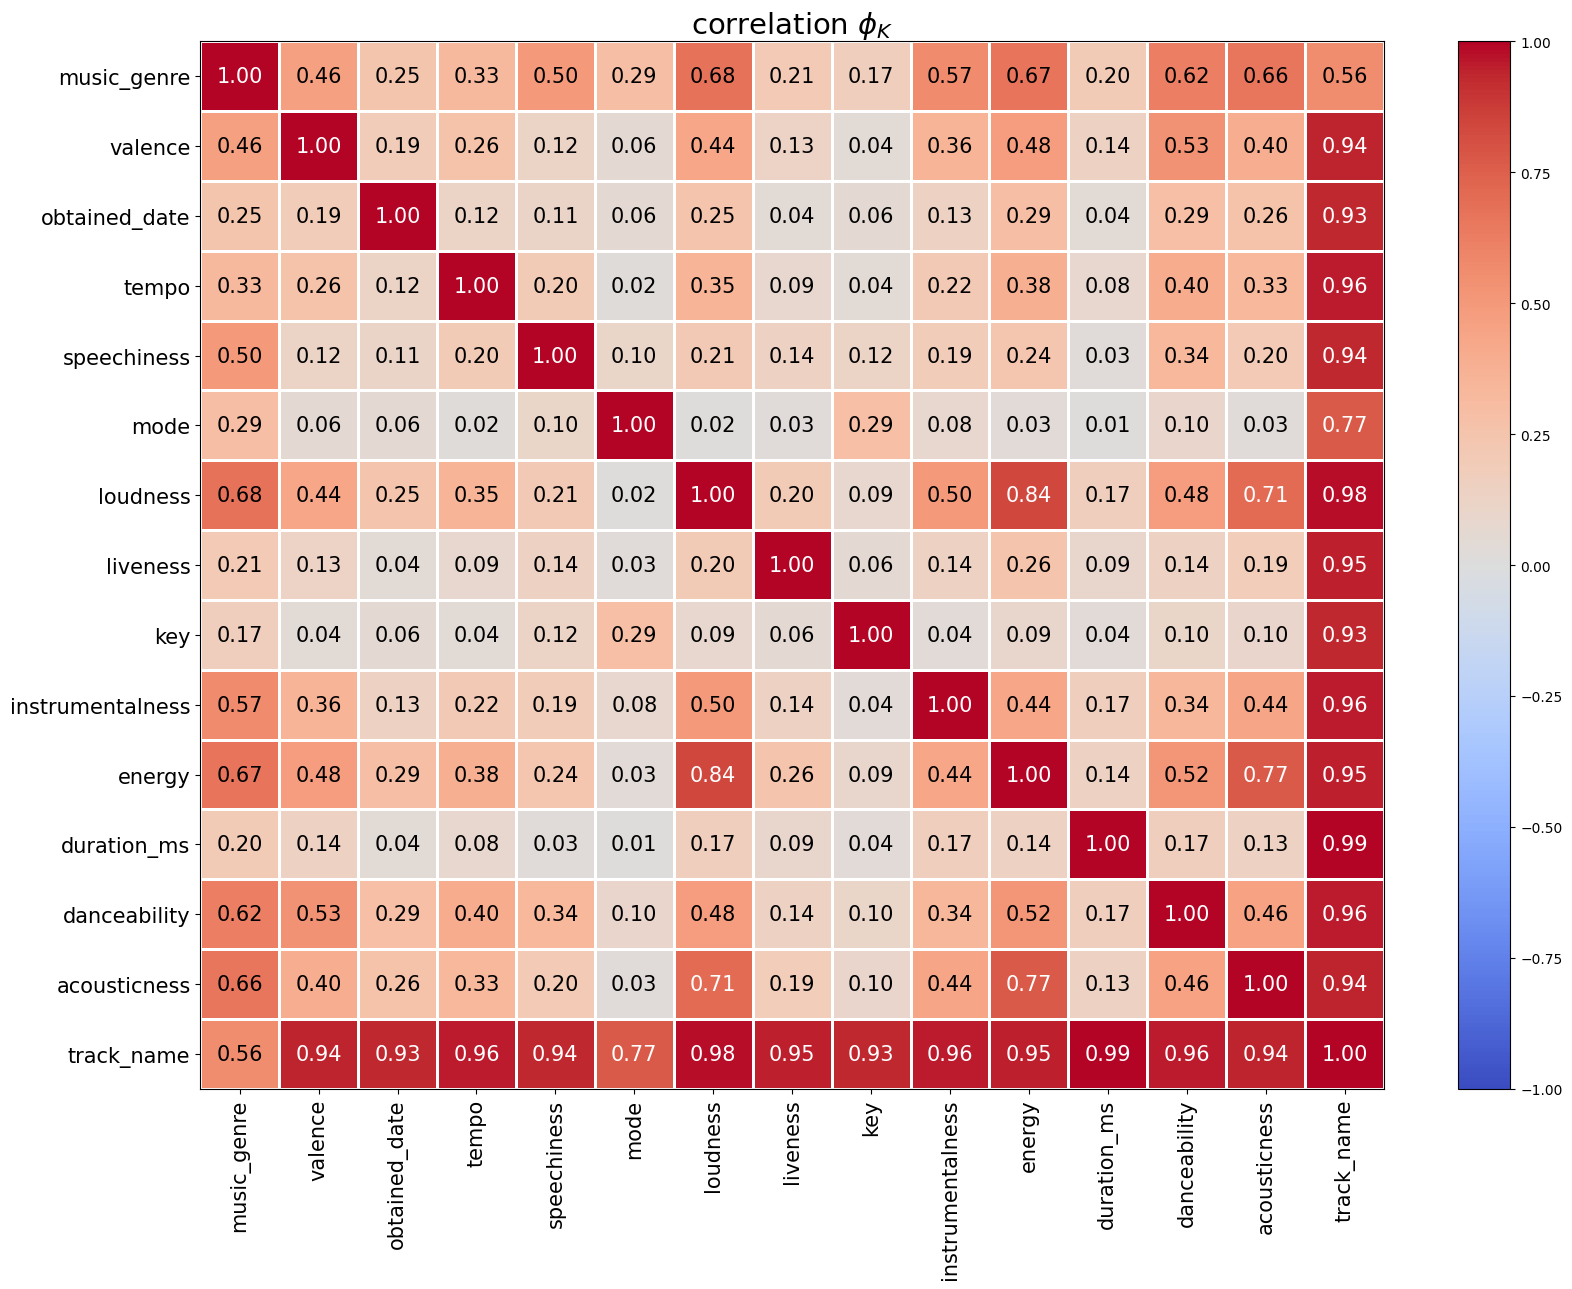

In [40]:
phik_overview = data.phik_matrix(interval_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
                                                'instrumentalness', 'liveness', 'loudness', 'speechiness',
                                                'tempo', 'valence']);
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                       color_map='coolwarm', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(17,13))
plt.tight_layout()

Из матрицы зависимостей видим, что energy и loudness зависимы с коэффициентом 0.84. Удалим столбец energy, так как music_genre менее зависим от него.

In [41]:
data = data.drop('energy', axis=1)
data_test = data_test.drop('energy', axis=1)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20394 non-null  object 
 1   acousticness      20394 non-null  float64
 2   danceability      20394 non-null  float64
 3   duration_ms       20394 non-null  float64
 4   instrumentalness  20394 non-null  float64
 5   key               20394 non-null  object 
 6   liveness          20394 non-null  float64
 7   loudness          20394 non-null  float64
 8   mode              20394 non-null  object 
 9   speechiness       20394 non-null  float64
 10  tempo             20394 non-null  float64
 11  obtained_date     20394 non-null  object 
 12  valence           20394 non-null  float64
 13  music_genre       20394 non-null  object 
dtypes: float64(9), object(5)
memory usage: 2.2+ MB


* Рассмотрел зависимость целевого признака от характеристик

* Проверил признаки на мультиколлинеарность, обнаружена нелинейная зависимсоть energy и loudness. Удалил столбец energy.

### Вектроное представление track_name

Со столбцом track_name можно еще поработать и преобразовать в вектор.

In [43]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stop = list(stop.union(set(punctuation))) #стопслова и пунктуация
ps = PorterStemmer()
pandarallel.initialize(progress_bar=True,use_memory_fs=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
def name_preprocess(txt):
    txt = simple_preprocess(txt)
    txt = [re.sub('[^a-z]', '', t) for t in txt]
    #ps = PorterStemmer()
    txt = [ps.stem(w) for w in txt]
    s = []
    for w in txt:
        if w not in stop:
            s.append(w)
    return ' '.join(s)

In [45]:
t_d = data.track_name.copy()
t_d = t_d.parallel_apply(name_preprocess)

In [46]:
t_d_test = data_test.track_name.copy()
t_d_test = t_d_test.parallel_apply(name_preprocess)

Добавил функцию, которая оставляет только слова на английском яззыке, применяет стемминг и избавляется от стоп-слов.

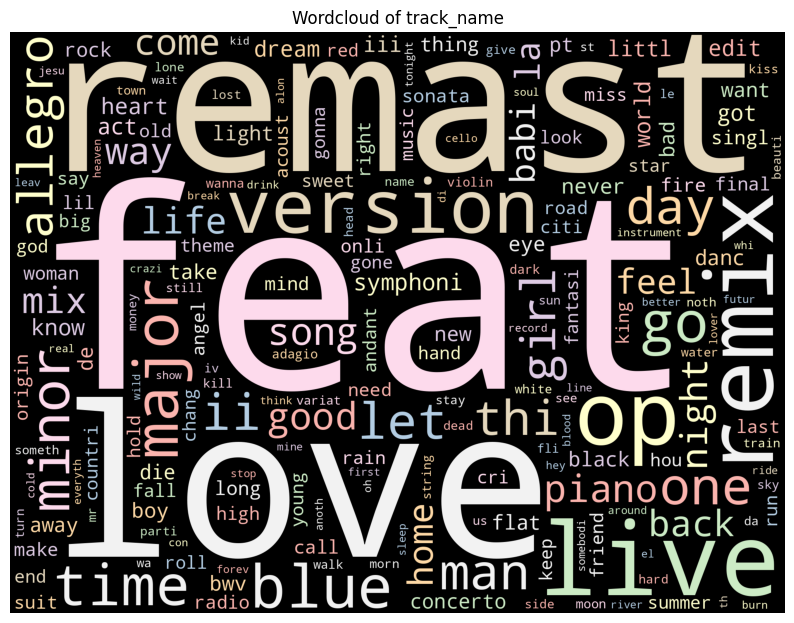

In [47]:
wordcloud = WordCloud(width = 2000, height = 1500, random_state=1, background_color='black', margin=20,
                      colormap='Pastel1', collocations=False).generate(' '.join(t_d))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title('Wordcloud of track_name')
plt.imshow(wordcloud);

Так выглядит облако слов, видно, что в названии фигурирует много различных слов, характеризующих жанр. Например, op, vesion, feat, remix и тд.

Использую tf-idf. Поставил ограничение на частоту встречаемости слова в документе 0.7. Использую метод главных компонент для сокращения размерности до 128 признаков.

In [48]:
#train
tf_idf_vec = TfidfVectorizer(max_df=0.7)#, ngram_range=1)#max_features=300
tf_idf = tf_idf_vec.fit_transform(t_d)
print(tf_idf.shape)
pca1 = PCA(n_components=128)
emb_pca1 = pca1.fit_transform(tf_idf.toarray())
emb_pca1.shape

(20394, 10645)


(20394, 128)

In [49]:
header = ['tf_idf_'+str(i) for i in range(128)]
tr = pd.DataFrame(emb_pca1, columns=header)
data = pd.concat([tr, data], axis=1)
data.shape

(20394, 142)

In [50]:
#test
tf_idf = tf_idf_vec.transform(t_d_test)
print(tf_idf.shape)
emb_pca1 = pca1.transform(tf_idf.toarray())
print(emb_pca1.shape)
tr = pd.DataFrame(emb_pca1, columns=header)
data_test = pd.concat([tr, data_test], axis=1)
data_test.shape

(5099, 10645)
(5099, 128)


(5099, 141)

In [51]:
data = data.drop('track_name', axis=1)
data_test = data_test.drop('track_name', axis=1)

Объединил признаки в один датафрейм. И заменил track_name на векторное представление.

### Подготовка данных к обучению

In [52]:
scaler = StandardScaler()
target_enc = LabelEncoder()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

In [53]:
#кодирую жанры
target_enc = LabelEncoder()
data['music_genre'] = target_enc.fit_transform(data['music_genre'])
data.sample(3)

,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,tf_idf_8,tf_idf_9,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
15192,-0.010500,-0.006079,-0.003731,-0.011300,-0.006306,0.001822,0.000432,0.006801,0.003134,-0.011101,...,0.86600,C#,0.132,-17.984,Major,0.0546,116.095,5-Apr,0.0365,1
1066,-0.000561,0.000456,-0.020904,-0.029868,0.063606,-0.020920,0.058098,0.003216,0.018395,-0.210974,...,0.00622,G,0.152,-17.017,Minor,0.0468,115.843,4-Apr,0.5640,2
8171,-0.008646,0.081671,-0.056882,-0.002078,-0.011394,0.003569,-0.001025,0.001245,-0.000846,0.003625,...,0.89700,D#,0.163,-19.310,Minor,0.0499,52.753,4-Apr,0.0274,3


In [54]:
X_train, X_test, y_train, y_test = (
    train_test_split(data.drop('music_genre', axis=1), data['music_genre'], test_size=0.25,
                     random_state=st, stratify=data.music_genre))
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15295, 140)
(5099, 140)
(15295,)
(5099,)


Разбил выборку на тренировочную и тестовую в отношении 3:1.

In [55]:
cat_columns = X_train.select_dtypes(include='object').columns
print(len(cat_columns))
num_columns = X_train.select_dtypes(include='number').columns
len(num_columns)

3


137

Выделил категориальные и числовые признаки.

In [56]:
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

Масштабировал числовые признаки.

In [57]:
encoder.fit(X_train[cat_columns])

train_enc = pd.DataFrame(encoder.transform(X_train[cat_columns]),
             columns=cat_columns)
test_enc = pd.DataFrame(encoder.transform(X_test[cat_columns]),
             columns=cat_columns)
X_train_enc = pd.concat([X_train[num_columns], train_enc], axis=1)
X_test_enc = pd.concat([X_test[num_columns], test_enc], axis=1)

print(X_train_enc.shape)
print(X_test_enc.shape)
X_train_enc.sample(3)

(15295, 140)
(5099, 140)


,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,tf_idf_8,tf_idf_9,...,duration_ms,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,obtained_date
8516,-0.166537,-0.161693,-0.056301,-0.146248,-0.077746,0.037281,0.063798,0.128227,0.050581,-0.167099,...,-0.566067,-0.522719,0.152460,-0.054485,0.871052,0.131729,0.050167,2.0,0.0,2.0
5371,-0.179773,-0.165804,-0.090516,-0.183288,-0.007517,0.027417,0.132020,0.159765,0.067828,-0.270653,...,0.728102,-0.522734,-0.065191,-0.037076,-0.620727,-0.348747,-0.790748,2.0,0.0,2.0
3067,5.820481,-0.460300,0.092687,-0.082277,-0.052087,0.251850,-0.220814,0.167593,-0.053945,0.040097,...,-1.069237,-0.522734,-0.379575,-0.478664,-0.404987,0.619050,-0.860482,1.0,0.0,2.0


In [58]:
ohe.fit(X_train[cat_columns])

train_ohe = pd.DataFrame(ohe.transform(X_train[cat_columns]).toarray(),
             columns=ohe.get_feature_names_out())
test_ohe = pd.DataFrame(ohe.transform(X_test[cat_columns]).toarray(),
             columns=ohe.get_feature_names_out())
X_train_ohe = pd.concat([X_train[num_columns], train_ohe], axis=1)
X_test_ohe = pd.concat([X_test[num_columns], test_ohe], axis=1)

print(X_train_ohe.shape)
print(X_test_ohe.shape)
X_train_ohe.sample(3)

(15295, 153)
(5099, 153)


,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,tf_idf_8,tf_idf_9,...,key_E,key_F,key_F#,key_G,key_G#,key__,mode_Minor,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
2339,-0.160366,-0.184292,-0.040415,-0.129086,-0.071887,0.057190,0.064934,0.124652,0.039571,-0.161452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14341,-0.161968,-0.306339,-0.021926,-0.261307,-0.117555,-0.164651,0.333492,0.072616,0.027076,-0.344142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3634,-0.337497,-0.893647,-0.284763,1.405786,-1.250919,6.282230,-0.364802,-1.760772,-0.555483,1.646192,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Закодировал категориальные признаки с помощью OrdinalEncoder.

## Выбор наилучшей модели

In [59]:
metrics = {'f1_micro':make_scorer(f1_score, average='micro')}#Целевая метрика.

In [60]:
dum = DummyClassifier(random_state=st)
dum.fit(X_train_enc, y_train)
preds = dum.predict(X_test_ohe)
print('f1_micro:', round(f1_score(preds, y_test, average='micro'), 2))

f1_micro: 0.14


Dummy модель дала слабый результат, нужны более сложные модели.

In [ ]:
lr = GridSearchCV(LogisticRegression(random_state=st, C=1, multi_class='multinomial'),
                  {'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
                 refit='f1_micro', scoring=metrics, cv=StratifiedKFold(7), error_score='raise')
lr.fit(X_train_ohe, y_train)
print(lr.best_params_)
#print('f1:', lr.best_score_)
print(f"f1_micro: {lr.cv_results_['mean_test_f1_micro'][0]: .4f}")
#print(f"accuracy: {lr.cv_results_['mean_test_accuracy'][0]: .4f}")

{'solver': 'saga'}
f1_micro:  0.4095


Логистическая регрессия дала неплохую метрику. Для этой модели я использовал данные, которые кодировал ohe. Для деревянных и бустинговых моделей использовал OrdinalEncoder.

In [63]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Используется GPU")
else:
    device = torch.device("cpu")
    print("Используется CPU")

Используется GPU


In [ ]:
xgb = XGBClassifier(objective='multi:softprob', learning_rate=0.02,
                    silent=True, tree_method='gpu_hist', n_estimators=800)
params = {
        'depth': [10, 12, 14],
        'learning_rate': [0.03, 0.05]
        }

CV_xgb = GridSearchCV(xgb, param_grid=params, refit='f1_micro', scoring=metrics,
                      cv=StratifiedKFold(5), error_score='raise', n_jobs=1);
CV_xgb.fit(X_train_enc, y_train);
print(CV_xgb.best_params_)
print(f"f1_micro: {CV_xgb.cv_results_['mean_test_f1_micro'][0]: .4f}")

{'depth': 10, 'learning_rate': 0.03}
f1_micro:  0.4697


In [115]:
mlp = MLPClassifier(solver='adam', alpha=0.001, learning_rate='adaptive')
param = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [200, 250, 300],
    'activation': ['tanh', 'relu']
}

CV_mlp = GridSearchCV(mlp, param_grid=param, refit='f1_micro', scoring=metrics,
                      cv=StratifiedKFold(5), error_score='raise', n_jobs=-1);
CV_mlp.fit(X_train_enc, y_train);
print(CV_mlp.best_params_)
print(f"f1_micro: {CV_mlp.cv_results_['mean_test_f1_micro'][0]: .4f}")

{'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'max_iter': 200}
f1_micro:  0.3478


Наилучший результат дал бустинговая модель XGBClassifier с метрикой на кроссвалидации f1_micro=0.47

## Тестирование наилучшей модели

In [66]:
xgb = XGBClassifier(objective='multi:softprob', booster='dart', depth=10,
                    silent=True, tree_method='gpu_hist', n_estimators=1000,
                    learning_rate=0.03, n_jobs=4, device=device, verbose=3)
xgb.fit(X_train_enc, y_train)
preds = xgb.predict(X_test_enc)
print('f1_micro:', f1_score(preds, y_test, average='micro'))

f1_micro: 0.46656207099431257


Итоговая метрика равна 0.466

## Получение предсказаний для соревнования

In [ ]:
#Получение предсказаний
#predictions_rfc = xgb.predict(data_test_ordinal)
#pred = pd.Series(predictions_rfc, name='music_genre')
#pred = pd.DataFrame(test_id).join(pred)
#pred['music_genre'] = pred.apply(encode_target, axis=1)
#pred.to_csv('predictions_rfc.csv', index=False)

## Оценка значимости признаков

Я выделю наиболее значимые признаки среди всех 140ка.

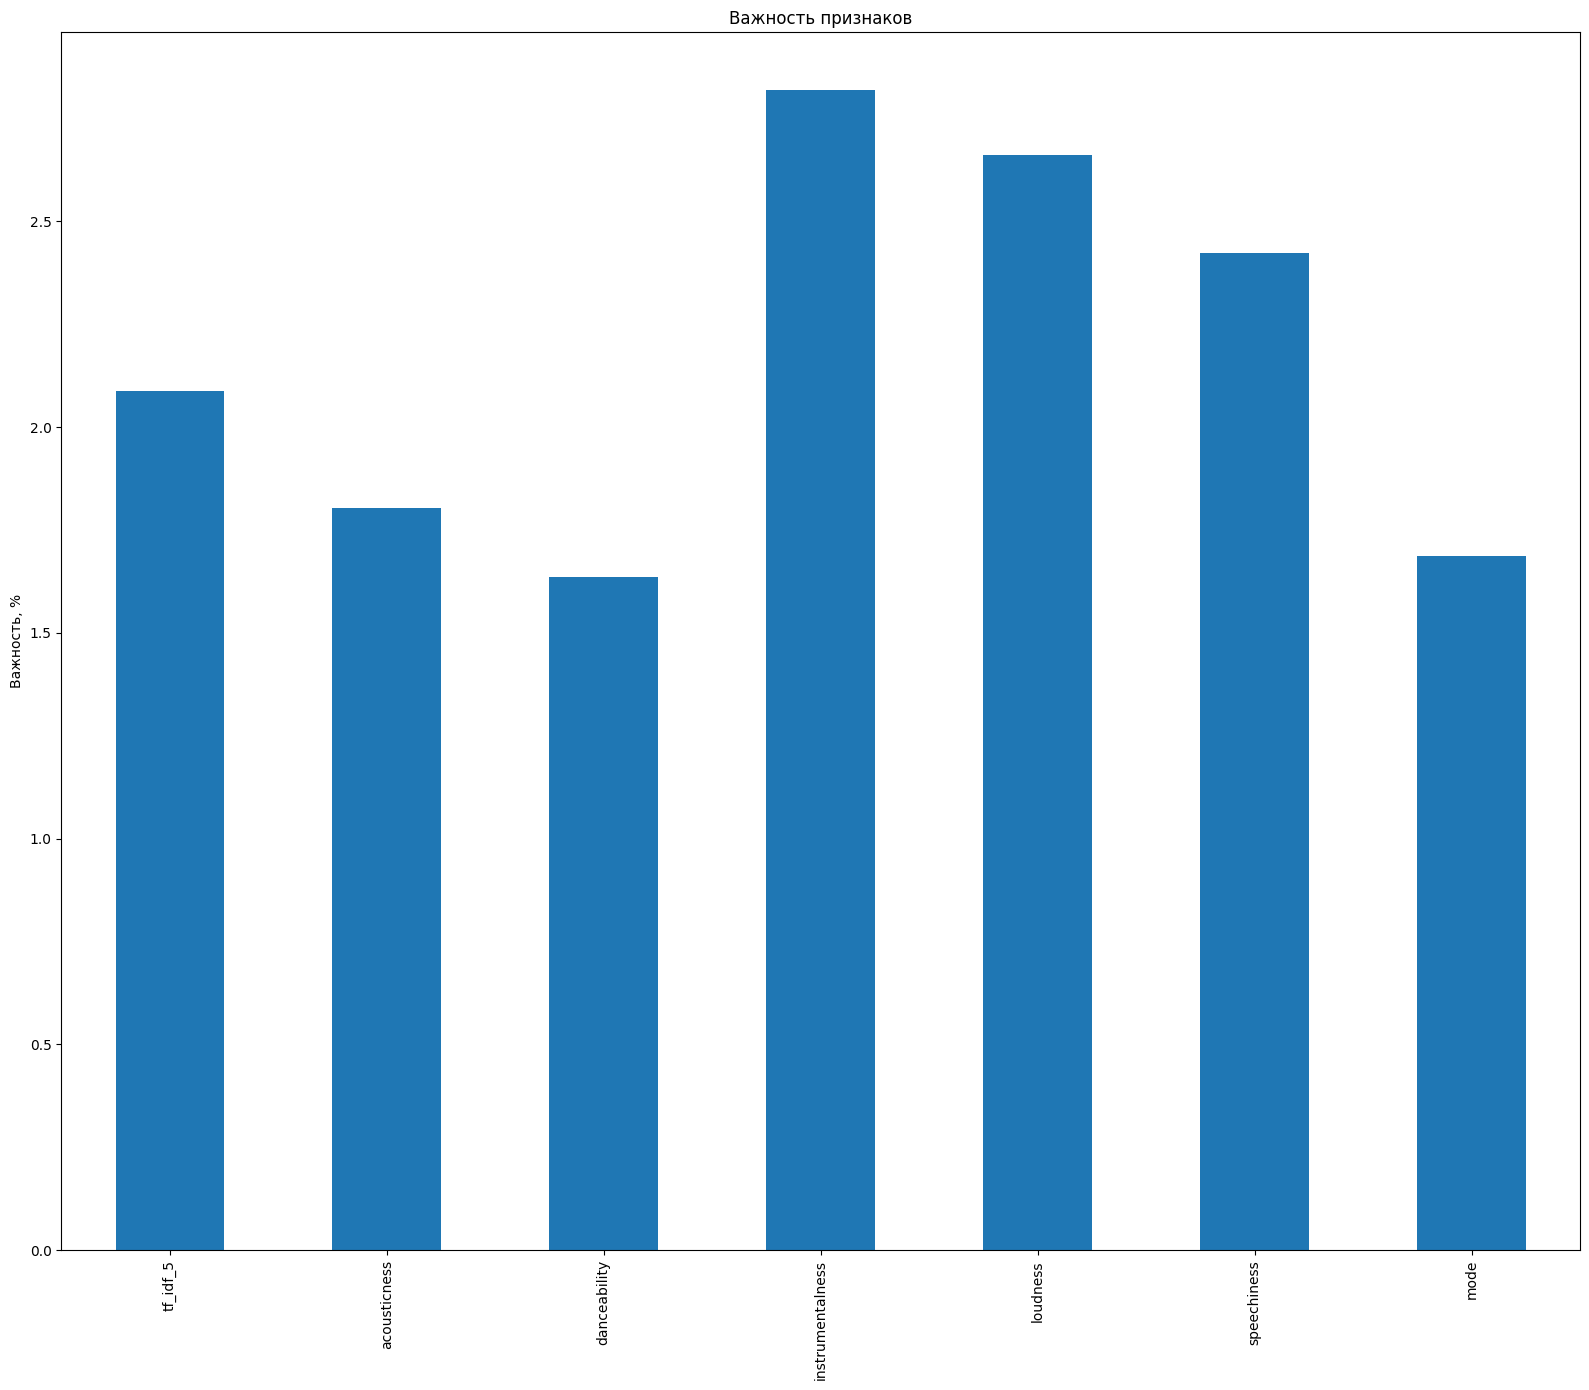

In [113]:
importance = pd.Series(xgb.feature_importances_,
                         X_train_enc.columns)*100
importance = importance.loc[importance>1.5]
fig, ax = plt.subplots(figsize=(16,14))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Как видно из графика, наиболее значимыми для модели признаками являются инструментальность, громкость, наличие речи и векторное представление названия трека.

## Вывод

Предобработка данных:

* Рассмотрел распределение признаков.
    
* Избавился от пропусков.

* С типами данных все в порядке.

* В столбце *duration_ms* были отрицательные значения, обработал эти выбросы.

Разведовачный анализ:

* Рассмотрел зависимости целевого признака от количественных признаков.

* Из матрицы зависимостей видим, что energy и loudness зависимы с коэффициентом 0.84. Удалим столбец energy, так как music_genre менее зависим от него.

Подготовка данных к обучению.

* Закодировал целевой признак.

* Применил метод OrdinalEncoding и OHE для категориальных данных.

* Разделил данные на тренировочную и тестовую выборки, учитывая баланс целевого признака в stratify.

Выбор модели:

* Рассматривал модели `DummyClassifier`, `LogisticRegression`, `XGBClassifier` и `MLPClassifier`.

* Для подбора гиперпараметров и оценки целевой метрики использовал кроссвалидацию.

Обучение модели на лучшей выборки

* Лучшую метрику на тестовых данных показала модель `XGBClassifier` f1_micro = 0.466

Оценка значимости признаков

* Как видно из графика, наиболее значимыми для модели признаками являются инструментальность, громкость, наличие речи и векторное представление названия трека.

Таким образом, я разработал модель для предсказания жанра композиции по ее характеристикам.